In [99]:
# 数据处理
import pandas as pd
import numpy as np

# 模型和评估
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# 数据分割和交叉验证
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

# 特征预处理
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

  Params: n_estimators=50, max_depth=3, learning_rate=0.001, Validation RMSE: 13.3770
  Params: n_estimators=50, max_depth=3, learning_rate=0.05, Validation RMSE: 6.8345
  Params: n_estimators=50, max_depth=3, learning_rate=0.1, Validation RMSE: 6.4343
  Params: n_estimators=50, max_depth=3, learning_rate=0.2, Validation RMSE: 6.2740
  Params: n_estimators=50, max_depth=5, learning_rate=0.001, Validation RMSE: 13.3386
  Params: n_estimators=50, max_depth=5, learning_rate=0.05, Validation RMSE: 7.1986
  Params: n_estimators=50, max_depth=5, learning_rate=0.1, Validation RMSE: 6.7655
  Params: n_estimators=50, max_depth=5, learning_rate=0.2, Validation RMSE: 6.7232
  Params: n_estimators=50, max_depth=7, learning_rate=0.001, Validation RMSE: 13.3383
  Params: n_estimators=50, max_depth=7, learning_rate=0.05, Validation RMSE: 7.3220
  Params: n_estimators=50, max_depth=7, learning_rate=0.1, Validation RMSE: 7.1264
  Params: n_estimators=50, max_depth=7, learning_rate=0.2, Validation RMSE:

KeyboardInterrupt: 

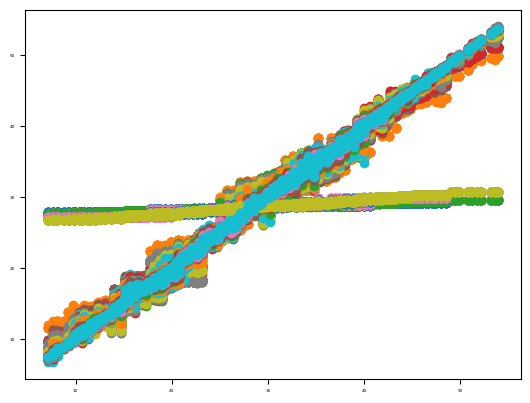

In [100]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('parkinsons_updrs.data')

# 定义目标变量和特征
random_state = 42
y = df['total_UPDRS']
X = df.loc[:, ~df.columns.isin(['total_UPDRS', 'test_time', 'Jitter(%)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer','Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA'])]
groups = df['subject#']


# Split into test and other sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.8, random_state=random_state)
test_idx, other_idx = next(gss.split(X, y, groups))

X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]

# 定义参数和结果存储
param_grid = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.001, 0.05, 0.1, 0.2]
}
num_states = 10  # Number of random states for evaluation

# 用于存储结果
test_scores = []
best_models = []

group_kfold = GroupKFold(n_splits=4)

for train_idx, val_idx in group_kfold.split(X_other, y_other, groups_other):
    # Train and validation split
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

    # Preprocessing pipeline
    onehot_ftrs = ['sex']
    std_ftrs = ['age', 'motor_UPDRS', 'Jitter(Abs)', 'Shimmer(dB)', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)
        ]
    )

    clf = Pipeline(steps=[('preprocessor', preprocessor)])

    X_train_prep = clf.fit_transform(X_train)
    X_val_prep = clf.transform(X_val)
    X_test_prep = clf.transform(X_test)

    # 手动调参
    best_params = None
    best_val_rmse = float('inf')
    best_model = None


    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                # Initialize XGBRegressor
                model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=random_state)
                
                # Fit on training data
                model.fit(X_train_prep, y_train)
                
                # Evaluate on validation set
                y_val_pred = model.predict(X_val_prep)
                val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                y_train_pred = model.predict(X_train_prep)
                plt.scatter(y_train, y_train_pred,label=f'{n_estimators:.0f}_{max_depth:.0f}_{learning_rate:.3f}')
                
                print(f"  Params: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate}, Validation RMSE: {val_rmse:.4f}")
                
                # Save the best model
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_params = (n_estimators, max_depth, learning_rate)
                    best_model = model

    # 测试集上评估最佳模型
    y_test_pred = best_model.predict(X_test_prep)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_scores.append(test_rmse)
    best_models.append(best_model)

    print(f"Best Params: {best_params}, Test RMSE: {test_rmse:.4f}")

# 计算最终结果
mean_rmse = np.mean(test_scores)

# 打印最终结果
print("\nFinal Results:")
print(f"Test RMSE Scores for Each Random State: {test_scores}")
print(f"Average Test RMSE: {mean_rmse:.4f}")

print(np.std(test_scores))

# 输出表现最佳的模型
best_model_index = np.argmin(test_scores)
global_best_model = best_models[best_model_index]
print("\nBest Model Across All Random States:")
print(global_best_model)


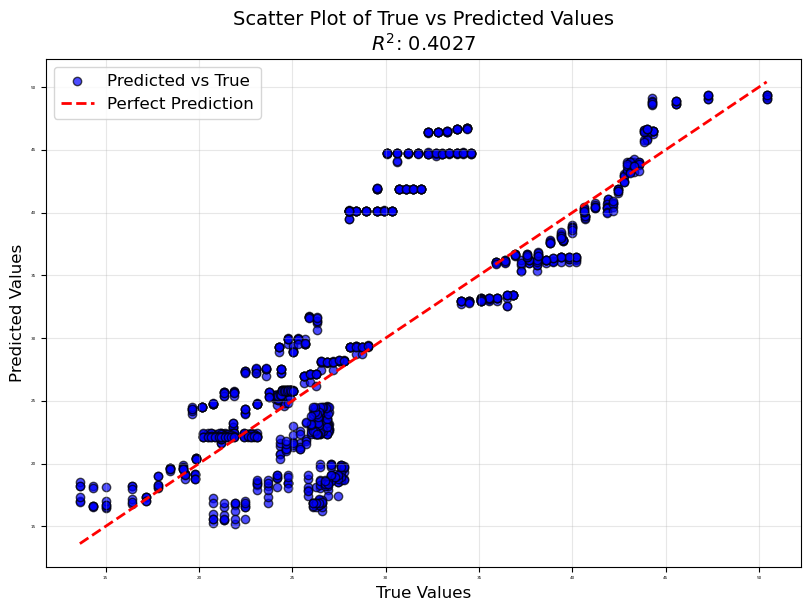

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test, y_test_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Scatter Plot of True vs Predicted Values\n$R^2$: {r2:.4f}", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


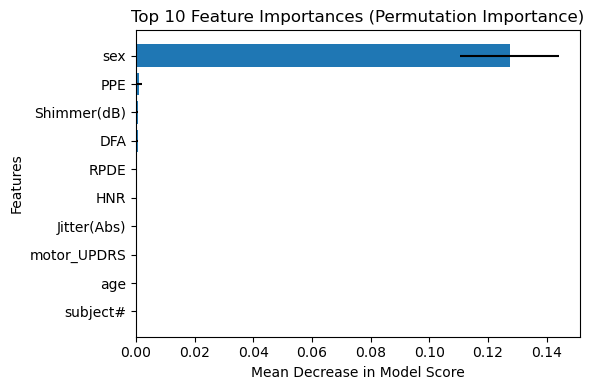

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
import pickle

# Save the model, preprocessed data, and feature names

ftr_names = X_test.columns 

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump((global_best_model, X_test, y_test, ftr_names), file)

# Load the model, preprocessed data, and feature names
with open('xgboost_model.pkl', 'rb') as file:
    model, X_test, y_test, ftr_names = pickle.load(file)

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Extract feature names and importance values
importances = perm_importance.importances_mean
stds = perm_importance.importances_std

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
top_10_indices = sorted_indices[:10]  # Get indices of top 10 features

# Prepare for visualization
top_10_features = ftr_names[top_10_indices]
top_10_importances = importances[top_10_indices]
top_10_stds = stds[top_10_indices]

# Plot the top 10 most important features
plt.figure(figsize=(6, 4))
plt.barh(top_10_features, top_10_importances, xerr=top_10_stds, align='center')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.xlabel("Mean Decrease in Model Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


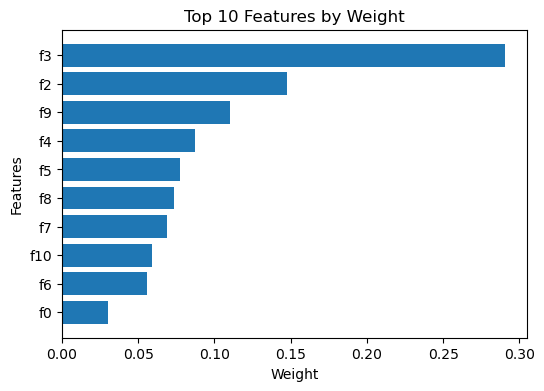

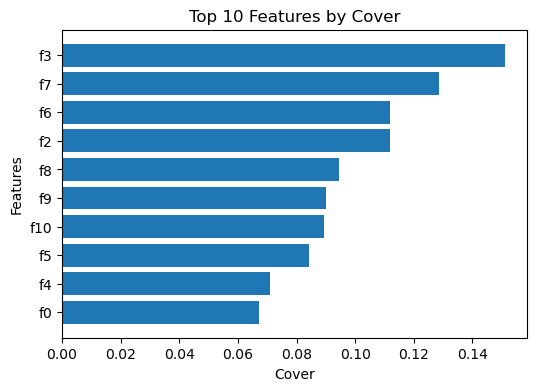

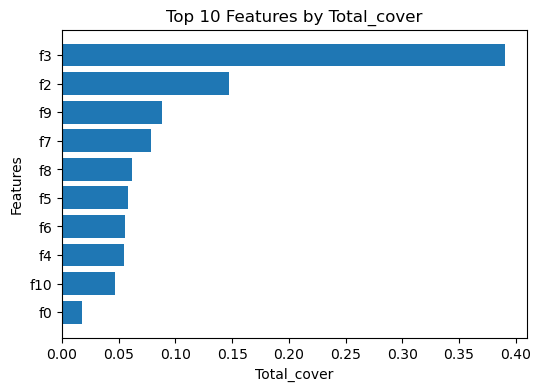

In [ ]:
# your code here
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# Assume `XGB` is your trained XGBoost model

# Retrieve feature importance metrics
importance_types = ['weight',  'cover', 'total_cover']
importance_data = {}

feature_names = X.columns  # 从 DataFrame 获取列名
booster = global_best_model.get_booster()
booster.feature_names = list(feature_names)

# Retrieve feature importance metrics
importance_data = {}
for imp_type in importance_types:
    importance = booster.get_score(importance_type=imp_type)
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    top_features = sorted_importance[:10]
    # 替换 f0, f1... 为实际列名
    top_features = [(feature_names[int(key[1:])], value) for key, value in top_features]
    importance_data[imp_type] = top_features


# Visualization for each metric
for imp_type, top_features in importance_data.items():
    features, values = zip(*top_features)
    # 或归一化
    values = np.array(values)
    values = values / values.sum()  # 将值归一化为比例
    plt.figure(figsize=(6, 4))
    plt.barh(features, values, align='center')
    plt.gca().invert_yaxis()  # Most important feature on top
    plt.title(f"Top 10 Features by {imp_type.capitalize()}")
    plt.xlabel(imp_type.capitalize())
    plt.ylabel("Features")
    plt.tight_layout


Force Plot for Data Point Index 1131


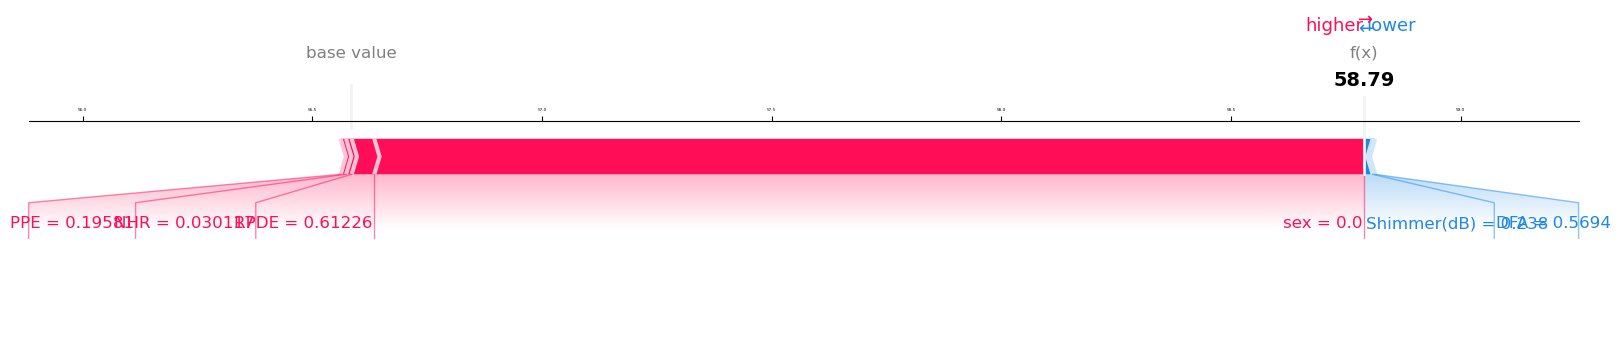

Force Plot for Data Point Index 32


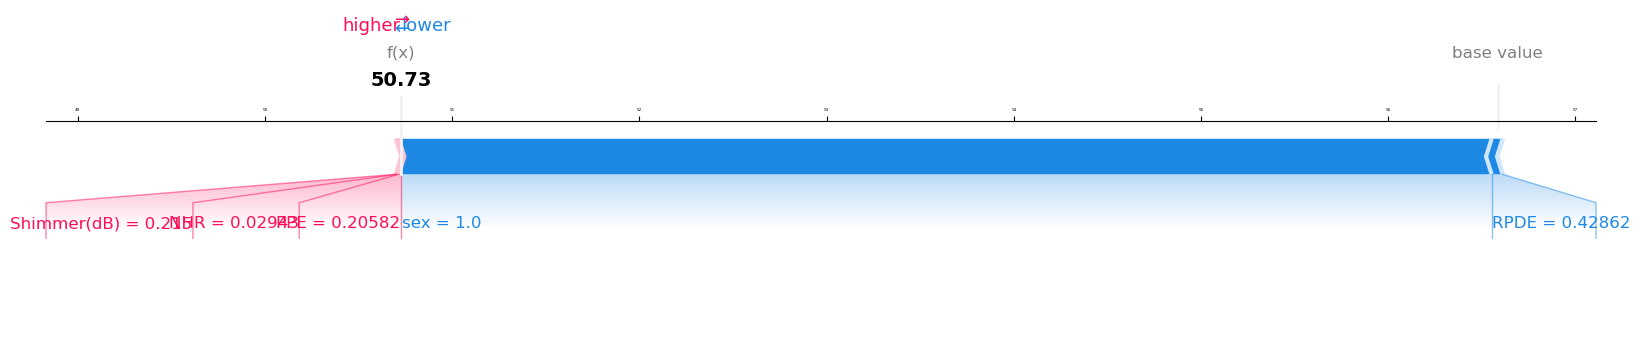

Force Plot for Data Point Index 25


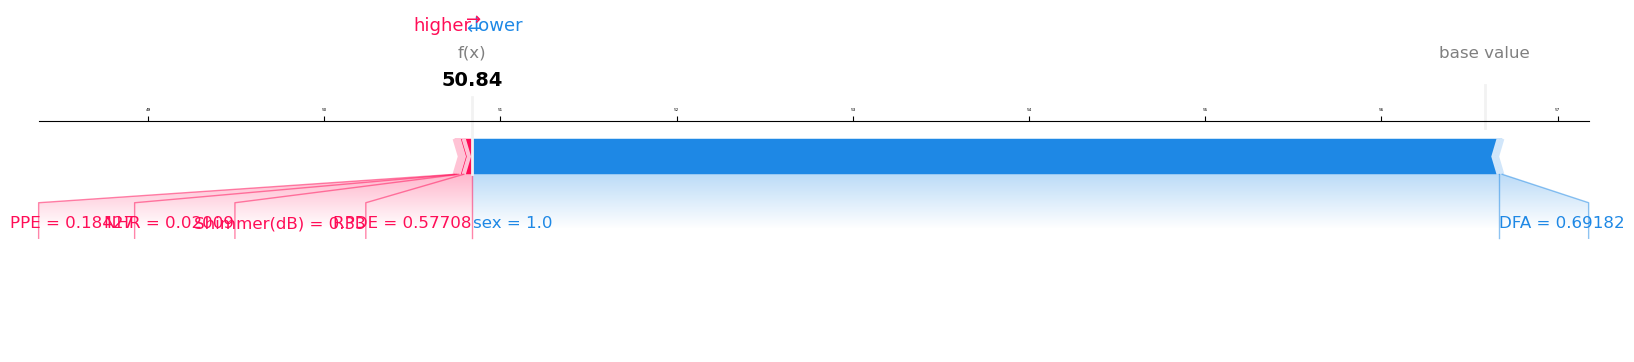

In [101]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 假设 X_test 是测试集，global_best_model 是训练好的 XGBoost 模型
# 示例数据 (替换为你的实际数据加载方式)
# X_test = pd.read_csv('your_test_data.csv')
# global_best_model = your_trained_model


# 创建 SHAP Explainer
explainer = shap.Explainer(global_best_model, X_test)  # 使用 XGBoost 模型和测试集创建 explainer
shap_values = explainer(X_test)  # 计算 SHAP 值

# 选择要绘制的特定数据点
indices = [1131, 32, 25]  # 替换为你的数据点索引

# 遍历每个数据点并绘制 force plot
shap.initjs()
for idx in indices:
    print(f"Force Plot for Data Point Index {idx}")
    shap.force_plot(
        explainer.expected_value,  # 模型的基准值
        shap_values[idx].values,  # 当前实例的 SHAP 值
        X_test.iloc[idx],  # 当前实例的特征值
        matplotlib=True  # Use Matplotlib for plotting
        
    )
    plt.show()
